# Time Related: KDE based Anomaly Detection

This notebook uses Colab to perform anomaly detection based on Kernel Density Estimation(KDE) algorithms via PySpark.


Data Source: [CERT Dataset](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=508099) from Carnegie Mellon University  

## Build environment

Since Colab does not have PySpark module installed, we need to install PySpark and configure the related environment first.

In [1]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 70kB/s 
     |████████████████████████████████| 204kB 45.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=75b873b2a71c0ed691246f86df7cf8a8938f96e81f4a5ca1dc63ea4059ee4045
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please locate to the location where this notebook is saved.

In [3]:
import os
cur_path = "/content/drive/MyDrive/insider-risk-in-spark/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/insider-risk-in-spark


Start Spark session.

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('proj').getOrCreate()

Import necessary modules.

In [5]:
from pyspark.sql.functions import to_timestamp, hour, minute, second
from pyspark.mllib.stat import KernelDensity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Load data

In [6]:
device = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/device.csv',inferSchema=True,header=True)
email = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/email.csv',inferSchema=True,header=True)
file = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/file.csv',inferSchema=True,header=True)
logon = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/logon.csv',inferSchema=True,header=True)
psychometric = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/psychometric.csv',inferSchema=True,header=True)
user_file = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/user_file.csv',inferSchema=True,header=True)

In [7]:
user_file.show(5)

+---+----------+-------+---+
|_c0|  new_date|   user| id|
+---+----------+-------+---+
|  0|2010-01-02|ABK3081|  1|
|  1|2010-01-02|NSR2539|  6|
|  2|2010-01-02|NRT1320|  1|
|  3|2010-01-02|NBT3447|  1|
|  4|2010-01-02|MWG1570|  4|
+---+----------+-------+---+
only showing top 5 rows



In [9]:
user_file.groupBy('user').count().show()

+-------+-----+
|   user|count|
+-------+-----+
|MKM0647|  206|
|TDV3188|  239|
|XUC1092|  208|
|BRH1107|   25|
|HBS2551|   44|
|MSH1269|   68|
|MRW2504|   20|
|RJS3479|   23|
|OJB1538|    9|
|MDG0657|   37|
|RJM3957|   19|
|DFC3287|   10|
|ANC1950|  134|
|HHF1995|  149|
|RHO0678|   39|
|JCL0446|  356|
|WEV2867|   10|
|ELB3697|   17|
|ADG1430|   83|
|NGR2884|   56|
+-------+-----+
only showing top 20 rows



In [11]:
user_file.filter("user == 'MKM0647'").show()

+-----+----------+-------+---+
|  _c0|  new_date|   user| id|
+-----+----------+-------+---+
|  218|2010-01-04|MKM0647|  7|
| 2057|2010-01-06|MKM0647|  3|
| 2822|2010-01-07|MKM0647|  3|
| 3759|2010-01-08|MKM0647|  6|
| 5875|2010-01-12|MKM0647|  1|
| 7859|2010-01-14|MKM0647|  7|
|10568|2010-01-19|MKM0647|  4|
|12445|2010-01-21|MKM0647|  7|
|16077|2010-01-27|MKM0647|  2|
|17759|2010-01-29|MKM0647|  2|
|18820|2010-02-01|MKM0647|  4|
|21585|2010-02-04|MKM0647|  2|
|22511|2010-02-05|MKM0647|  1|
|23673|2010-02-08|MKM0647|  9|
|24676|2010-02-09|MKM0647|  2|
|25572|2010-02-10|MKM0647|  1|
|26430|2010-02-11|MKM0647|  6|
|27213|2010-02-12|MKM0647|  7|
|28133|2010-02-15|MKM0647|  4|
|30762|2010-02-18|MKM0647|  9|
+-----+----------+-------+---+
only showing top 20 rows



## Device related behavior

In [12]:
device = device.withColumn('date', to_timestamp(device.date, 'MM/dd/yyyy HH:mm:ss'))
device = device.withColumn('hour', hour('date')+minute('date')/60+second('date')/3600)
device.printSchema()
device.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- hour: double (nullable = true)

+--------------------+-------------------+-------+-------+----------+------------------+
|                  id|               date|   user|     pc|  activity|              hour|
+--------------------+-------------------+-------+-------+----------+------------------+
|{J1S3-L9UU75BQ-77...|2010-01-02 07:21:06|MOH0273|PC-6699|   Connect| 7.351666666666667|
|{N7B5-Y7BB27SI-29...|2010-01-02 07:37:41|MOH0273|PC-6699|Disconnect| 7.628055555555556|
|{U1V9-Z7XT67KV-56...|2010-01-02 07:59:11|HPH0075|PC-2417|   Connect|7.9863888888888885|
|{H0Z7-E6GB57XZ-16...|2010-01-02 07:59:49|IIW0249|PC-0843|   Connect| 7.996944444444445|
|{L7P2-G4PX02RX-79...|2010-01-02 08:04:26|IIW0249|PC-0843|Disconnect| 8.073888888888888|
+--------------------+-------------------+-------+-------+-----

In [43]:
file.count()

445581

In [13]:
def get_kde_graph(prob, new_hour, new_prob):
    prob_max = max(prob)
    prob_min = min(prob)
    all24hour = list(np.arange(0,24,0.1))

    plt.plot(all24hour,prob)
    plt.xlim(0, 24)
    plt.hlines(new_prob, 0, 24, colors = "red", alpha = 0.5)
    plt.vlines(new_hour, 0, prob_max, colors = "red", alpha = 0.5)
    plt.title("History KDE Curve")
    plt.show()

def get_score(new_hour, prob, kd):
    prob_max = max(prob)
    prob_min = min(prob)
    new_prob = kd.estimate([float(new_hour)])

    get_kde_graph(prob, new_hour, new_prob)

    risk_score = (prob_max-new_prob)/(prob_max - prob_min)
    return risk_score[0]


In [14]:
user = 'IIW0249'
new_hour = 12

In [15]:
all_device_connect_hour = device.where("activity == 'Connect'").select('hour')
kd_all_device = KernelDensity()
kd_all_device.setSample(all_device_connect_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_all_device = kd_all_device.estimate(all24hour)

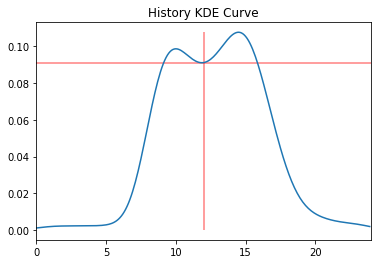

0.15492519216702494

In [16]:
get_score(new_hour, prob_all_device, kd_all_device)  

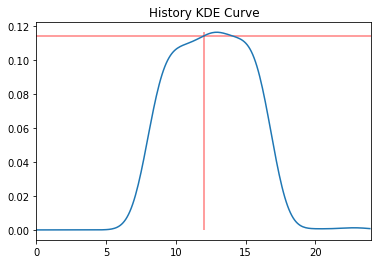

0.018223924062195616

In [17]:
personal_device_connect_hour = device.where("activity == 'Connect'").where("user == '"+ user +"'").select('hour')
kd_personal_device = KernelDensity()
kd_personal_device.setSample(personal_device_connect_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_personal_device = kd_personal_device.estimate(all24hour)

get_score(new_hour, prob_personal_device, kd_personal_device)  

## Email related behavior

In [22]:
email = email.withColumn('date', to_timestamp(email.date, 'MM/dd/yyyy HH:mm:ss'))
email = email.withColumn('hour', hour('date')+minute('date')/60+second('date')/3600)

email.printSchema()
email.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- to: string (nullable = true)
 |-- cc: string (nullable = true)
 |-- bcc: string (nullable = true)
 |-- from: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- attachments: integer (nullable = true)
 |-- content: string (nullable = true)
 |-- hour: double (nullable = true)

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+-----------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|             hour|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+--------

In [27]:
user = 'IIW0249'
new_hour = 12

In [28]:
all_email_hour = email.select('hour')
kd_all_email = KernelDensity()
kd_all_email.setSample(all_email_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_all_email = kd_all_email.estimate(all24hour)

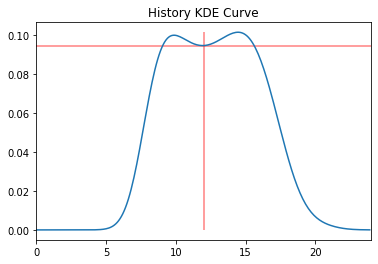

0.06735199145780646

In [29]:
get_score(new_hour, prob_all_email, kd_all_email)  

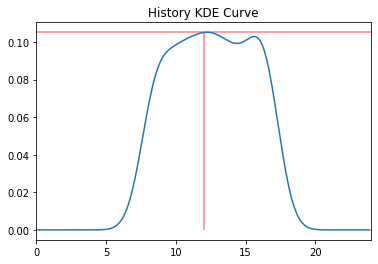

0.0012470606405618463

In [30]:
personal_email_hour = email.where("user == '"+ user +"'").select('hour')
kd_personal_email = KernelDensity()
kd_personal_email.setSample(personal_email_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_personal_email = kd_personal_email.estimate(all24hour)

get_score(new_hour, prob_personal_email, kd_personal_email)  

## File related behavior

In [31]:
file = file.withColumn('date', to_timestamp(file.date, 'MM/dd/yyyy HH:mm:ss'))
file = file.withColumn('hour', hour('date')+minute('date')/60+second('date')/3600)

file.printSchema()
file.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- content: string (nullable = true)
 |-- hour: double (nullable = true)

+--------------------+-------------------+-------+-------+------------+--------------------+-----------------+
|                  id|               date|   user|     pc|    filename|             content|             hour|
+--------------------+-------------------+-------+-------+------------+--------------------+-----------------+
|{L9G8-J9QE34VM-28...|2010-01-02 07:23:14|MOH0273|PC-6699|EYPC9Y08.doc|D0-CF-11-E0-A1-B1...|7.387222222222222|
|{H0W6-L4FG38XG-98...|2010-01-02 07:26:19|MOH0273|PC-6699|N3LTSU3O.pdf|25-50-44-46-2D ca...|7.438611111111111|
|{M3Z0-O2KK89OX-57...|2010-01-02 08:12:03|HPH0075|PC-2417|D3D3WC9W.doc|D0-CF-11-E0-A1-B1...|8.200833333333332|
|{E1I4-S4QS61TG-36...|2010-01-02 08:17:00|HPH0075|PC-2417|QCSW62YS.doc

In [32]:
user = 'IIW0249'
new_hour = 12

In [33]:
all_file_hour = file.select('hour')
kd_all_file = KernelDensity()
kd_all_file.setSample(all_file_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_all_file = kd_all_file.estimate(all24hour)

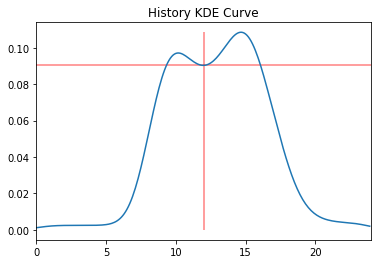

0.16931022905502685

In [34]:
get_score(new_hour, prob_all_file, kd_all_file)  

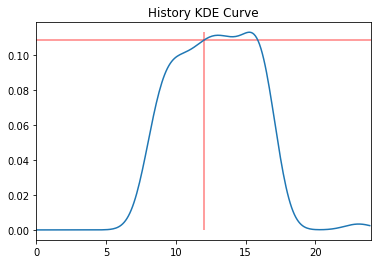

0.04065193121340499

In [35]:
personal_file_hour = file.where("user == '"+ user +"'").select('hour')
kd_personal_file = KernelDensity()
kd_personal_file.setSample(personal_file_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_personal_file = kd_personal_file.estimate(all24hour)

get_score(new_hour, prob_personal_file, kd_personal_file)  

## Logon related behavior

In [36]:
logon = logon.withColumn('date', to_timestamp(logon.date, 'MM/dd/yyyy HH:mm:ss'))
logon = logon.withColumn('hour', hour('date')+minute('date')/60+second('date')/3600)

logon.printSchema()
logon.show(5)

root
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- hour: double (nullable = true)

+--------------------+-------------------+-------+-------+--------+-----------------+
|                  id|               date|   user|     pc|activity|             hour|
+--------------------+-------------------+-------+-------+--------+-----------------+
|{X1D9-S0ES98JV-53...|2010-01-02 06:49:00|NGF0157|PC-6056|   Logon|6.816666666666666|
|{G2B3-L6EJ61GT-22...|2010-01-02 06:50:00|LRR0148|PC-4275|   Logon|6.833333333333333|
|{U6Q3-U0WE70UA-37...|2010-01-02 06:53:04|LRR0148|PC-4124|   Logon|6.884444444444444|
|{I0N5-R7NA26TG-62...|2010-01-02 07:00:00|IRM0931|PC-7188|   Logon|              7.0|
|{D1S0-N6FH62BT-53...|2010-01-02 07:00:00|MOH0273|PC-6699|   Logon|              7.0|
+--------------------+-------------------+-------+-------+--------+-----------------+
o

In [37]:
user = 'IIW0249'
new_hour = 12

In [38]:
all_logon_hour = logon.select('hour')
kd_all_logon = KernelDensity()
kd_all_logon.setSample(all_logon_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_all_logon = kd_all_logon.estimate(all24hour)

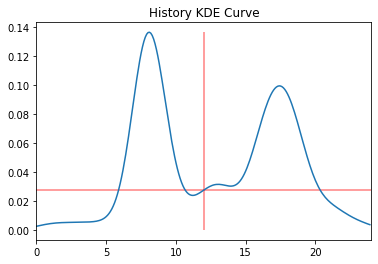

0.8134727121506795

In [39]:
get_score(new_hour, prob_all_logon, kd_all_logon)  

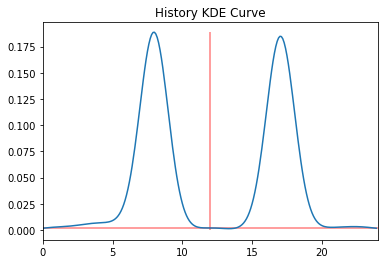

0.9965215934362192

In [40]:
personal_logon_hour = logon.where("user == '"+ user +"'").select('hour')
kd_personal_logon = KernelDensity()
kd_personal_logon.setSample(personal_logon_hour.rdd.map(lambda x: x[0]))

all24hour = list(np.arange(0,24,0.1))
prob_personal_logon = kd_personal_logon.estimate(all24hour)

get_score(new_hour, prob_personal_logon, kd_personal_logon)  

## Psychometric related behavior

In [ ]:
psychometric.printSchema()
psychometric.show(5)

root
 |-- employee_name: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- O: integer (nullable = true)
 |-- C: integer (nullable = true)
 |-- E: integer (nullable = true)
 |-- A: integer (nullable = true)
 |-- N: integer (nullable = true)

+--------------------+-------+---+---+---+---+---+
|       employee_name|user_id|  O|  C|  E|  A|  N|
+--------------------+-------+---+---+---+---+---+
|    Calvin Edan Love|CEL0561| 40| 39| 36| 19| 40|
|Christine Reagan ...|CRD0624| 26| 22| 17| 39| 32|
|Jade Felicia Cald...|JFC0557| 22| 16| 23| 40| 33|
|Aquila Stewart De...|ASD0577| 40| 48| 36| 14| 37|
|   Micah Abdul Rojas|MAR0955| 36| 44| 23| 44| 25|
+--------------------+-------+---+---+---+---+---+
only showing top 5 rows

